In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_selection import chi2
import seaborn as sns
from pprint import pprint

import string
import re
from stop_words import get_stop_words
import nltk, html

from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, train_test_split, ParameterGrid, KFold, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
''' ******Data Creation******'''

df = pd.read_csv(r'Desktop\development.csv')

X = df['text']
y = df['sentiment']

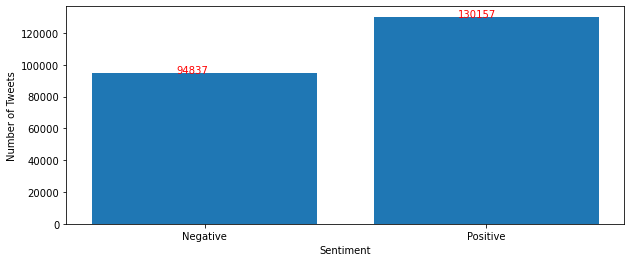

In [3]:
''' ******Data Exploration****** '''

count = Counter(y)
labels = ['Positive', 'Negative']
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(count.keys(), count.values(), tick_label = labels)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Tweets')
#fig.suptitle('Number of tweets in Category')
for index, data in enumerate(sorted(count.values())):
    plt.text(x = index - .1 , y = data + 2 , s=f"{data}" , fontdict=dict(fontsize=10), color='red')
plt.show()

In [4]:
''' ******Feature Engineering******'''

# =============Text Cleaning=============
stop_words = get_stop_words('english')
#instantiation for stemming
lemma = nltk.wordnet.WordNetLemmatizer()

def tokenize(doc):
    """Compute the tokens for each document.

    Input: a list of strings. Each item is a document to tokenize.
    Output: a list of lists. Each item is a list containing the tokens of the relative document.
    """
    tokens = []
    for tweet in doc:
        
        tweet = html.unescape(tweet) # Escaping out HTML characters
        tweet = tweet.replace('"', '') # quoting
        tweet = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", tweet) # removing email
        tweet = re.sub("(.)\\1{2,}", "\\1", tweet) # removing repeatetive letters in a word
        tweet = " ".join(tweet.split()) 
        tweet=tweet.lower() # convert to lower case
        split_doc = [lemma.lemmatize(token) for token in tweet.split(" ") if ((token not in stop_words) and (token not in string.punctuation))]
        target = ' '.join(split_doc) # getting sentence from a list
        
        tokens.append(target) # adding to final list
    return tokens

X_token = tokenize(X)

In [9]:
# =============Null Check=============
null_check = pd.Series(X_token)
print('number of null values in records: ', len(null_check[null_check.isna()]))

number of null values in records:  0


In [10]:
# =============Train-Test Split=============
X_train, X_test, y_train, y_test = train_test_split(X_token, y, test_size=.2, stratify=y, shuffle=True, random_state=42)

In [13]:
# =============Max Feature Tuning by Decision Tree=============
mf = [i for i in range(1000,11001,1000)]
f1_total = []
for mx in mf:
    tfidf = TfidfVectorizer(max_features=mx, lowercase=False, sublinear_tf=True)
    features_train = tfidf.fit_transform(X_train)
    labels_train = y_train
    print(features_train.shape)

    features_test = tfidf.transform(X_test)
    labels_test = y_test
    print(features_test.shape)
    print(tfidf.get_feature_names()[:50])
    clf = DecisionTreeClassifier()
    clf.fit(features_train, labels_train)
    y_pred = clf.predict(features_test)
    f = f1_score(y_pred, labels_test, average='macro')
    f1_total.append(f)
    print(mx, ' ' ,f)

(179995, 1000)
(44999, 1000)
['10', '100', '11', '12', '140', '15', '1st', '20', '2day', '2nd', '30', 'able', 'about', 'absolutely', 'account', 'actually', 'add', 'afternoon', 'again', 'age', 'ago', 'agree', 'ah', 'aha', 'ahh', 'aint', 'air', 'album', 'all', 'almost', 'alone', 'along', 'alot', 'already', 'alright', 'also', 'although', 'always', 'am', 'amazing', 'and', 'annoying', 'another', 'answer', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'apparently']
1000   0.6730699967419603
(179995, 2000)
(44999, 2000)
['00', '10', '100', '11', '12', '13', '14', '140', '15', '16', '17', '18', '1st', '20', '200', '2009', '21', '24', '25', '2day', '2morrow', '2nd', '2nite', '30', '33', '3rd', '40', '45', '4th', '50', '500', '80', '90', '__', '_x', '_xo', 'able', 'about', 'absolutely', 'abt', 'access', 'account', 'ache', 'across', 'act', 'acting', 'action', 'actually', 'ad', 'adam']
2000   0.6824465985837838
(179995, 3000)
(44999, 3000)
['00', '09', '10', '100', '10th', '11', '12', '13'

Text(0, 0.5, 'f1_score')

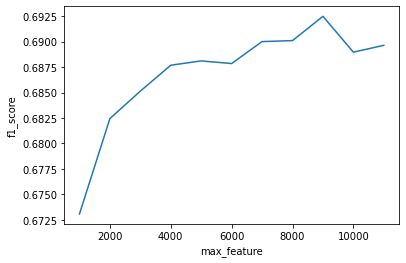

In [14]:
plt.plot(np.array(mf), f1_total)
plt.xlabel('max_feature')
plt.ylabel('f1_score')

In [15]:
# =============Text Representation/Feature Creation=============
tfidf = TfidfVectorizer(max_features=8000, lowercase=False, sublinear_tf=True)
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test)
labels_test = y_test
print(features_test.shape)

(179995, 8000)
(44999, 8000)


In [16]:
# =============Cosine Similarity=============
cosine_similarities = linear_kernel(features_train[0:1], features_train).flatten()
print(cosine_similarities[:10])

[1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.10283705]


In [18]:
''' ******Model Learning SVC******'''

# =============Support Vector=============
svc = svm.SVC(random_state = 8)
# =============Cross-Validation for Hyperparameter Tuning=============
# C
C = [.1, 1]

#gamma
gamma = [.001, .01, .1, 1]

# kernel for textual classification
kernel = ['linear']

#probability
probability = [True]

# Create the random grid
param_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'probability': probability
             }

In [19]:
# ============= Grid Search Cross-Validation=============
# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train[:15000], labels_train[:15000])

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=SVC(random_state=8),
             param_grid={'C': [0.1, 1], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear'], 'probability': [True]},
             scoring='f1_macro', verbose=1)

In [1]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:


NameError: name 'grid_search' is not defined

In [21]:
# =============Best Model=============
best_svc = grid_search.best_estimator_
best_svc

SVC(C=1, gamma=0.001, kernel='linear', probability=True, random_state=8)

In [22]:
# =============Model Fitting and Performance=============
best_svc.fit(features_train[:15000], labels_train[:15000])
svc_pred = best_svc.predict(features_test)

In [23]:
# =============Training accuracy=============
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
0.7483152309786383


In [24]:
# =============Test accuracy=============
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.7396831040689793
